### Imputation of Missing Data and Financial Analysis

#### Packages

In [1]:
# Load packages and check versions
import sys
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV


print('The Python version is {}.\n'.format(sys.version))
print('The Numpy version is {}.\n'.format(np.__version__))
print('The Pandas version is {}.\n'.format(pd.__version__))
print('The Matplotlib version is {}.\n'.format(mpl.__version__))
print('The Scikit-Learn version is {}.\n'.format(sklearn.__version__))

The Python version is 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0].

The Numpy version is 1.19.1.

The Pandas version is 1.1.0.

The Matplotlib version is 3.3.3.

The Scikit-Learn version is 0.24.0.



### Imputation of missing data

Imputation involves using the known values of a certain feature to make a best educated guess as to the missing values as a way to solve the problem of missing data that might have potential predictive power. 

Following are some strategies to deal with missing data:

- Ignore samples with missing data, or features with missing data
- Impute missing feature values with a constant (e.g. mean, median or mode) for a specific category
- Impute missing values using a random selection from non-missing values
- Impute missing values using interpolation of nearby observations in time or space
- Mode-based imputation

While the first option doesn't actually impute any data, it is a common practice among data science projects when dealing with missing values. 

The simplest types of imputation involve using a summary statistic of the non-missing feature values, as the single constant value with which to replace all the missing values. This summary statistic may be the mean, median, or mode for continuous features. For categorial features, the mode is an option, as well as the median for ordinal categoricals. An important additional case of imputation with a constant value for categorial variables is to create a new level of the categorical  variable, to indicate data is missing.

More sophisticated methods of imputation can be used to fill in missing values with non-constant values. These methods reflect an acknowledgment that the missing values may not all be equal. he simplest way to do this is to fill in missing values using a random draw from the set of non-missing values, with replacement. This way, the relative frequency of different values chosen to fill in missing data will be similar to the existing data for that feature.

In case samples are located within time or space, such as a time series or geolocated data, then temporal or spatial interpolation methods may be used. These methods follow the general idea that a missing data point is probably located somewhere between the values of adjacent data points in time or space.

Lastly, perhaps the most sophisticated way to fill in missing data is to view the imputation problem as a predictive modeling "problem within a problem." In this method, the feature with missing values is considered the response variable, while the features with no missing values are considered the features of this sub-problem.

### Preparing Samples with Missing Data

Note that for the case study dataset, the feature that had missing values was **pay_1**, which turned out to be the most important feature as dentified by both the univariate feature selection as well as the feature importance of the random forest. In order to test out different imputation strategies on the case study data and see how they affect the predictive capability of the modeling approach, it is necesasry to replace samples with missing data back in to the dataset.

Let us load the original dataset:

In [2]:
df = pd.read_excel('data/default_of_credit_card_clients__courseware_version_1_21_19.xls')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Looking at the zero rows:

In [3]:
df_zero_mask = df == 0
features_zero_mask = df_zero_mask.iloc[:, 1:].all(axis=1)

(sum(features_zero_mask),
 features_zero_mask)

(315,
 0        False
 1        False
 2        False
 3        False
 4        False
          ...  
 29995    False
 29996    False
 29997    False
 29998    False
 29999    False
 Length: 30000, dtype: bool)

Let us remove them from the dataframe and check whether all rows are unique:

In [4]:
df_clean = df.loc[~features_zero_mask].copy()

df_clean.shape

(29685, 25)

In [5]:
df_clean.id.nunique()

29685

Let us replace the undocumented values for the **education** and **marriage** columns with an *unknown* value.

Education shoul be "Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)"

Marriage should be "Marriage (1 = married; 2 = single; 3 = others)"

In [6]:
(df_clean.education.value_counts(), 
 df_clean.marriage.value_counts())

(2    13884
 1    10474
 3     4867
 5      275
 4      122
 6       49
 0       14
 Name: education, dtype: int64,
 2    15810
 1    13503
 3      318
 0       54
 Name: marriage, dtype: int64)

In [7]:
df_clean.education.replace(to_replace=[0,5,6], value=4, inplace=True)
df_clean.marriage.replace(to_replace=0, value=3, inplace=True)

Let us maintain the **pay_1** with missing values for the imputation process. However, let us "save" them into another set to include it the train and test set in a way to compare whether the imputation process reflects a better performance:

In [8]:
df_clean.pay_1.value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: pay_1, dtype: int64

In [9]:
missing_pay_1_mask = df_clean.pay_1 == 'Not available'
sum(missing_pay_1_mask)

3021

Now let us isolate these values:

In [10]:
df_missing_pay_1 = df_clean[missing_pay_1_mask].copy()
df_missing_pay_1.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
17,f0ba5e02-0c0f,320000,1,1,1,49,Not available,0,0,-1,...,70074,5856,195599,10358,10000,75940,20000,195599,50000,0
28,aecb449b-a999,50000,2,3,1,47,Not available,-1,-1,-1,...,2040,30430,257,3415,3421,2044,30430,257,0,0
29,57ea9a1f-cdd5,50000,1,1,2,26,Not available,0,0,0,...,17907,18375,11400,1500,1500,1000,1000,1600,0,0
54,781f3cc2-7ddc,150000,2,1,2,29,Not available,0,0,0,...,26518,21042,16540,1600,1718,1049,1500,2000,5000,0
60,5c00d7e6-a804,500000,2,3,1,28,Not available,0,0,0,...,14937,13827,15571,1516,1300,1000,1000,2000,2000,1


Let us now load the previously cleaned dataframe:

In [11]:
df_cleaned_before = pd.read_csv('data/default_of_credit_card_clients_cleaned.csv')
df_cleaned_before.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,education_cat,graduate_school,high_school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,1000,1000,1000,5000,0,university,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,1200,1100,1069,1000,0,university,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,10000,9000,689,679,0,university,0,0,0,1


Let us isolate the independent features:

In [12]:
features_response = df_cleaned_before.columns.tolist()
to_remove = ['id', 'sex'] + ['pay_{}'.format(i) for i in range(2,7)] + features_response[-5:]

features_response = [feature for feature in features_response if feature not in to_remove]
features_response

['limit_bal',
 'education',
 'marriage',
 'age',
 'pay_1',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6',
 'default_payment_next_month']

Now it is possible to test different imputation techniques for the *df_missing_pay_1*.

### Mode and Random Imputation of pay_1

Let us create a train and test sets for the cleaned df and add later the *df_missing_pay_1* to measure the impact of imputation in the model's performance.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned_before[features_response[:-1]].values,
                                                    df_cleaned_before.default_payment_next_month.values,
                                                    test_size=0.2, random_state=24)

Let us create an imputation for the **pay_1** column (this feature has the index 4 in the *feature_response* list) with the mode (the median has the same value of mode, so only one statistic is left anyway):

In [14]:
np.median(X_train[:, features_response.index('pay_1')])

0.0

And now, let us create the imputation values for the two strategies that will be adopted: one imputing the node and another imputing values from a random normal sampling from the **pay_1** train set. Besides, let us create proper column names to track them correctly:

In [15]:
fill_values = [0, np.random.choice(X_train[:, features_response.index('pay_1')], size=(3021,), replace=True)]
fill_strategy = ['mode', 'random']

Before continue, let us verify whether the distributions of the random generated sampling process is the same as the **pay_1** train set:

Text(0.5, 1.0, 'Pay_1 random generated distribution')

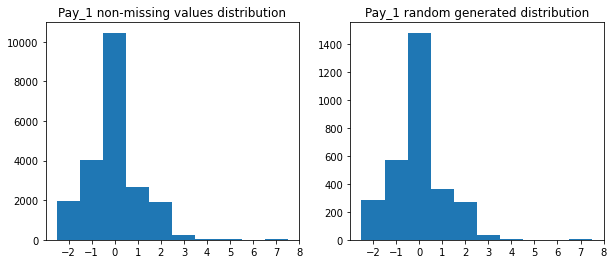

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

bin_edges = np.arange(-2, 9)

ax[0].hist(X_train[:, 4], bins=bin_edges, align='left')
ax[0].set_xticks(bin_edges)
ax[0].set_title('Pay_1 non-missing values distribution')

ax[1].hist(fill_values[1], bins=bin_edges, align='left')
ax[1].set_xticks(bin_edges)
ax[1].set_title('Pay_1 random generated distribution')

The two distributions were very similar. Only the scale of the *y*-axis indicated that there were fewer imputed values than in the original dataset. This showed that the values for **pay_1** faithfully imitated the relative frequency of different values of this feature in the data.

Now, let us set up the cross-validation to compare imputation methods using the same hyperparameters for the best model estimation.

In [17]:
k_folds = KFold(n_splits=4, shuffle=True, random_state=1)
rf = RandomForestClassifier(n_estimators=200, max_depth=9)

The shuffle was set to true because the imputed values will be appended to the training set and it is interesting to not concentrate them into one fold.

In [18]:
for imputation_method in range(len(fill_values)):

    # Copy the data frame with missing pay_1 and assign imputed values
    df_filled_pay_1 = df_missing_pay_1.copy()
    df_filled_pay_1.pay_1 = fill_values[imputation_method]

    # Split imputated data in train and test sets, using the same test size proportion
    X_filled_train, X_filled_test, y_filled_train, y_filled_test = \
        train_test_split(df_filled_pay_1[features_response[:-1]].values,
                         df_filled_pay_1.default_payment_next_month.values,
                         test_size=0.2, random_state=24)

    # Concatenate the imputed data with the array of non-missing data
    X_train_all = np.concatenate((X_train, X_filled_train), axis=0)
    y_train_all = np.concatenate((y_train, y_filled_train), axis=0)

    # Use the KFolds splitter and the Random Forest estimator for cross-validation
    imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
                                           cv=k_folds, n_jobs=-1, verbose=1, return_estimator=True,
                                           return_train_score=True, error_score='raise')

    # Compute scores
    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[imputation_method] + ' imputation: ' +
          'mean testing score: ' + str(np.mean(test_score)) +
          ', std: ' + str(np.std(test_score)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   16.3s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


mode imputation: mean testing score: 0.7726360518601779, std: 0.0034249519057662913


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   13.2s remaining:   13.2s


random imputation: mean testing score: 0.7689596062480133, std: 0.0031130701342771397


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   13.8s finished


The two imputation strategies had very similar performances. However, the simplest imputation strategy, just filling in all missing values of pay_1 with the most common value of 0 from the non-missing samples, performed better. The average testing score (ROC AUC) across the four folds was 0.773 for mode imputation, versus 0.769 using random imputation.

The average test score without any imputation was 0.776, thus, the model had experienced a little degradation in the estimate of out-of-sample model testing performance. This was to be expected, as there were included data that had issues and uncertainties. However, this was still within 0.006 ROC AUC units of the best score observed when working with the non-missing data, so it's not too much lower.

### A predictive Model to estimate pay_1 samples

The most accurate, but also the most labor-intensive way to impute a feature with missing values is to create a predictive model for that feature. This method uses more information compared to simpler methods:

- The simplest methods like mean, median, mode, and random selection just use information from non-missing values of the feature.
- Intermediately complex methods like interpolation use additional information about how "close" a given sample is to other samples, in the spatial or temporal context, and leverage this for more accurate imputation.
- The model-based imputation uses all features without missing values, to predict the missing values of the affected feature. Therefore, model-based imputation is similar to any other predictive model, where we consider the feature with missing values to be the response variable.

The model to predict missing values for pay_1 feature will be a multiclass classifier (with a categorical response variable). The possible classes will range from -2 to 8 (the possible values for this feature). 

Let us define the dataset for the pay_1 estimation (the following dataframe represents the data for training and testing). Again, let us remove undesired (and unethical) features:

In [19]:
pay_1_df = df_cleaned_before.copy()

features_response = df_cleaned_before.columns.tolist()
to_remove = ['id', 'sex'] + ['pay_{}'.format(i) for i in range(2,7)] + features_response[-6:]

features_response = [feature for feature in features_response if feature not in to_remove]
features_response2 = [feature for feature in features_response if feature not in to_remove + ['pay_1']]

Let us use a Random Forest to build the multiclass classifier (partially because it readily accepts multiclass classificatoin as a built-in feature). Besides let us use the accuracy as the comparative metrics (again, it is easier this way):

In [20]:
X_impute_train, X_impute_test, y_impute_train, y_impute_test = \
    train_test_split(pay_1_df[features_response2].values,
                     pay_1_df.pay_1.values, test_size=0.2, random_state=24)

Let us set some hyperparameters and instantiate the GridSearch object:

In [21]:
params = {'max_depth': [3, 6, 9, 12],
          'n_estimators': [10, 50, 100, 200]}

cv_rf_imputation = GridSearchCV(rf, param_grid=params, scoring='accuracy',
                                n_jobs=-1, refit=True, cv=4, error_score=np.nan,
                                return_train_score=True)

And train the models:

In [22]:
cv_rf_imputation.fit(X_impute_train, y_impute_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=9, n_estimators=200),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy')

Let us extract the best params and save the results:

In [23]:
cv_rf_imputation_df = pd.DataFrame(cv_rf_imputation.cv_results_)

print('Best params: ' + str(cv_rf_imputation.best_params_) + 
      ', best score: ', cv_rf_imputation.best_score_)
cv_rf_imputation_df

Best params: {'max_depth': 12, 'n_estimators': 200}, best score:  0.7324083446794569


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.284487,0.014170,0.015234,0.000934,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.657979,0.635665,0.673542,0.645349,0.653134,0.014193,14,0.662833,0.637017,0.670459,0.651978,0.655572,0.012565
1,1.291420,0.014307,0.069795,0.005771,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.662291,0.643540,0.653853,0.663916,0.655900,0.008094,13,0.670021,0.644768,0.645081,0.673605,0.658369,0.013504
2,2.576802,0.031427,0.145561,0.005048,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.642790,0.655916,0.663979,0.639535,0.650555,0.009883,15,0.648769,0.652894,0.655769,0.649853,0.651821,0.002735
3,5.114408,0.040801,0.286068,0.015248,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.642415,0.645603,0.653853,0.642161,0.646008,0.004728,16,0.647956,0.644581,0.647206,0.653978,0.648430,0.003440
4,0.469608,0.026224,0.015845,0.000641,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.708982,0.711419,0.709169,0.707239,0.709202,0.001485,12,0.719840,0.722403,0.717590,0.716420,0.719063,0.002287
5,2.147239,0.017658,0.073946,0.004831,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.712732,0.709732,0.714232,0.706489,0.710796,0.002968,10,0.721403,0.719652,0.719340,0.718045,0.719610,0.001198
6,4.275059,0.030307,0.155807,0.015696,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.709544,0.709544,0.716482,0.706677,0.710562,0.003613,11,0.719527,0.719402,0.721340,0.717670,0.719485,0.001299
7,8.509234,0.048167,0.305010,0.025332,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.712170,0.709919,0.716670,0.705739,0.711124,0.003946,9,0.719652,0.717652,0.719402,0.718732,0.718860,0.000774
8,0.616415,0.017996,0.017793,0.000209,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.723045,0.721170,0.721545,0.719617,0.721344,0.001219,7,0.774847,0.767408,0.773409,0.763485,0.769787,0.004585
9,2.953979,0.026682,0.082817,0.003514,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.728858,0.724545,0.726795,0.726369,0.726642,0.001533,6,0.769971,0.768534,0.775159,0.769736,0.770850,0.002547


Let us examine the score comparing to a dumb predictor over all fractions:

In [24]:
pay_1_value_counts = pay_1_df.pay_1.value_counts().sort_index()

pay_1_value_counts / np.sum(pay_1_value_counts)

-2    0.092859
-1    0.189281
 0    0.490812
 1    0.122300
 2    0.089184
 3    0.010951
 4    0.002363
 5    0.000863
 6    0.000413
 7    0.000338
 8    0.000638
Name: pay_1, dtype: float64

From the fractions, 49% of the values were equal to the mode. So, using the mode imputation, the imputation value would be expected to be correct about 49% of the time. However, using a model to impute the values of pay_1, the results showed that 73% of the time was correct. So, one benefit of using model-based imputation was that more accurate fill values for the unknown values of a feature were found.

Let us see if the model generalizes well to the test set:

In [25]:
y_impute_predict = cv_rf_imputation.predict(X_impute_test)

metrics.accuracy_score(y_impute_test, y_impute_predict)

0.738983686480405

The accuracy on the test set of 74% was comparable to, and a little higher than, the average cross-validation accuracy of 73%.

Let us know check the distribution of the preicted classes for this feature and compare to the true values:

Text(0.5, 1.0, 'Pay_1 model-based test set distribution')

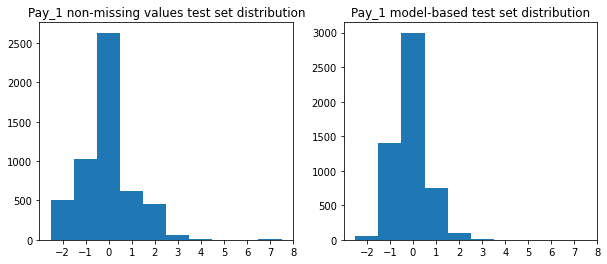

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

bin_edges = np.arange(-2, 9)

ax[0].hist(y_impute_test, bins=bin_edges, align='left')
ax[0].set_xticks(bin_edges)
ax[0].set_title('Pay_1 non-missing values test set distribution')

ax[1].hist(y_impute_predict, bins=bin_edges, align='left')
ax[1].set_xticks(bin_edges)
ax[1].set_title('Pay_1 model-based test set distribution')

From the above figure, it is possible to see that the model was more likely to predict a value of 0 for **pay_1** than existed in the test set. However, the distribution was quite similar to the test set, compensating this behaviour.

Now, let us train with all the available pay_1 feature data and held-out a test set that was from the non available values:

In [27]:
X_impute_all, y_impute_all = pay_1_df[features_response2].values, pay_1_df.default_payment_next_month.values

rf_impute = RandomForestClassifier(n_estimators=50, max_depth=12)
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(max_depth=12, n_estimators=50)

Now let us use the model to predict the missing values:

In [28]:
df_filled_pay_1_model = df_missing_pay_1.copy()
df_filled_pay_1_model['pay_1'] = rf_impute.predict(df_filled_pay_1_model[features_response2].values)

df_filled_pay_1_model.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
17,f0ba5e02-0c0f,320000,1,1,1,49,0,0,0,-1,...,70074,5856,195599,10358,10000,75940,20000,195599,50000,0
28,aecb449b-a999,50000,2,3,1,47,0,-1,-1,-1,...,2040,30430,257,3415,3421,2044,30430,257,0,0
29,57ea9a1f-cdd5,50000,1,1,2,26,0,0,0,0,...,17907,18375,11400,1500,1500,1000,1000,1600,0,0
54,781f3cc2-7ddc,150000,2,1,2,29,0,0,0,0,...,26518,21042,16540,1600,1718,1049,1500,2000,5000,0
60,5c00d7e6-a804,500000,2,3,1,28,0,0,0,0,...,14937,13827,15571,1516,1300,1000,1000,2000,2000,1


Let us check the predicted distribution:

In [29]:
df_filled_pay_1.pay_1.value_counts().sort_index()

-2     287
-1     569
 0    1479
 1     366
 2     269
 3      37
 4       5
 5       1
 6       2
 7       2
 8       4
Name: pay_1, dtype: int64

It is possible to see that there was a range of prediction values of pay_1 from the imputation model, roughly in the relative frequencies that were expected.

Now let us use all the data so far (the imputed and not imputed) and train a random forest with the same hyperparameters to check if the model presents a better performance:

In [ ]:
X_filled_train, X_filled_test, y_filled_train, y_filled_test = \
    train_test_split(df_filled_pay_1_model[features_response].values,
                     df_filled_pay_1_model.default_payment_next_month.values,
                     test_size=0.2, random_state=24)

X_train_all = np.concatenate((X_train, X_filled_train), axis=0)
y_train_all = np.concatenate((y_train, y_filled_train), axis=0)

imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc', cv=k_folds,
                                       return_train_score=True, error_score='raise', n_jobs=-1,
                                       verbose=1, return_estimator=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
(np.mean(imputation_compare_cv['test_score']),
 np.std(imputation_compare_cv['test_score']))

An average cross-validated ROC AUC of 0.772 was very close to, but slightly worse than, the previous best result of 0.775 from mode-based imputation. For all intents and purposes, mode-based and model-based imputations had essentially the same performance. Note that the standard deviation for cross-validation score with model-based imputation calculated above is 0.003, so the average model-based imputation score is within one standard deviation of the best method.

From a simplicity standpoint, the mode-based imputation was the clear favorite. The code to implement this was much more concise than the model-based imputation just completed.

### Mesuring the Imputed Model on Test set

Let us reassign the values with the mode value and verify how the model with mode imputation goes:

In [ ]:
df_filled_pay_1_model.pay_1 = np.zeros_like(df_filled_pay_1_model.pay_1.values)
df_filled_pay_1_model.pay_1.unique()

In [ ]:
X_filled_train, X_filled_test, y_filled_train, y_filled_test = \
    train_test_split(df_filled_pay_1_model[features_response].values,
                     df_filled_pay_1_model.default_payment_next_month.values,
                     test_size=0.2, random_state=24)

X_train_all = np.concatenate((X_train, X_filled_train), axis=0)
X_test_all = np.concatenate((X_test, X_filled_test), axis=0)
y_train_all = np.concatenate((y_train, y_filled_train), axis=0)
y_test_all = np.concatenate((y_test, y_filled_test), axis=0)

print(X_train_all.shape)
print(X_test_all.shape)
print(y_train_all.shape)
print(y_test_all.shape)

In [ ]:
rf.fit(X_train_all, y_train_all)

Let us extract the probabilities of the predictions:

In [ ]:
y_test_all_predict_proba = rf.predict_proba(X_test_all)
roc_auc_score(y_test_all, y_test_all_predict_proba[:, 1])

The appropriate comparison to make here was with the cross-validated testing score computed using the mode-imputed pay_1, which was 0.773. It is possible to see that the testing score of 0.770 was roughly within 1 standard deviation of the cross-validation estimate. 

The conclusion is that he model is robust and is ready for delivery to the client.

### Financial Analysis

To go the extra mile and make the connection of the mathematical world of predicted probabilities and thresholds, to the business world of costs and benefits, a financial analysis of some kind is usually required.

For a binary classification model like that of the case study, here are a few questions that the data scientist needs to know the answers to, in order to figure out how to apply the model for the client:

- What kinds of decisions does the client want to use the model to help them make?
- How can the predicted probabilities of a binary classification model be used to help make these decisions?
- Are they yes/no decisions? Then choosing a single threshold of predicted probability will be sufficient.
- Are there more than two levels of activity that will be decided on, based on model results? Then choosing 2 or more thresholds, for example to sort predictions in to low, medium, and high risk, may be the solution. In this case, predicted probabilities below 0.5 may be considered low risk, those between 0.5 and 0.75 medium risk, and those above 0.75 high risk.
- What are the costs of taking all the different courses of action that are available, based on model guidance?
- What are the potential benefits to be gained from successful actions taken as a result of model guidance?

Let us consider the following scenario. For credit accounts that are at a high risk of default, the client is designing a new program to provide individualized counseling for the account holder, to encourage them to pay their bill on time or provide alternative payment options if that will not be possible. Credit counseling is performed by trained customer service representatives who work in a call center. The cost per attempted counseling session is NT$7,500 and the expected success rate of a session is 70%, meaning that on average 70% of the recipients of phone calls offering counseling will pay their bill on time, or make alternative arrangements that are acceptable to the creditor. The potential benefits of successful counseling are that the amount of an account's monthly bill will be realized as savings, if it was going to default but instead didn't, as a result of the counseling. Currently, the monthly bills for accounts that default are reported as losses.

The client would like us to help them decide which members to contact and offer credit counseling to. If we can help them narrow down the list of people who will be contacted for counseling, we can help save them money by avoiding unnecessary and expensive contacts. The clients' limited resources for counseling will be more appropriately spent on accounts that are at higher risk of default. Therefore, our analysis should focus on finding anappropriate threshold of predicted probability, by which we may divide our accounts in to two groups: higher risk accounts that will receive counseling and lower risk ones that won't.

### Characterizing Costs and Savings

First, let us create different thresholds for the possible probabilities that the model will output:

In [ ]:
thresholds = np.linspace(0, 1, 101)

Let us use mean bill amount to estimate savings per prevented default:

In [ ]:
savings_per_default = np.mean(X_test_all[:, 5]) # 5 -> Bill Amount; Taking the mean as an estimation per account.
savings_per_default

Now let us declare the cost per counseling and the estimate effectiveness of the program:

In [ ]:
cost_per_counseling = 7500
effectiveness = 0.70

The average of the most recent months' bill across all accounts is NT\\$51,602. So, using the assumption that this is the opportunity for savings of a prevented default for each account, the net savings after a cost of NT\\$7,500 for credit counseling will be NT\\$44,102. This indicates a potential for net savings in the credit counseling program.

In [ ]:
savings_per_default - cost_per_counseling

The issue is that not all accounts will default. For an account that wouldn't default, a counseling session represents a wasted NT\\$7,500. Our analysis needs to balance the costs of counseling with the risk of default.

Now, we will calculate costs and savings for each of the thresholds.

In [ ]:
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)

n_true_pos = np.empty_like(thresholds)
savings_of_all_counselings = np.empty_like(thresholds)

In [ ]:
counter = 0

for threshold in thresholds:

    pos_pred = y_test_all_predict_proba[:, 1] > threshold
    true_pos = pos_pred & y_test_all.astype(bool)
    
    n_true_pos[counter] = sum(true_pos)
    n_pos_pred[counter] = sum(pos_pred)

    cost_of_all_counselings[counter] = n_pos_pred[counter] * cost_per_counseling
    savings_of_all_counselings[counter] = savings_per_default * n_true_pos[counter] * effectiveness

    counter += 1

Now, let us calculate the net saving (savings - costs):

In [ ]:
net_savings = savings_of_all_counselings - cost_of_all_counselings

Let us display the net saving distribution:

In [ ]:
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

The plot indicated that the choice of threshold was important. While it was possible to create net savings at many different values of the threshold, it looks like the highest net savings was generated by setting the threshold somewhere in the range of about 0.2 to 0.25.

Let confirm the optimal threshold:

In [ ]:
max_saving_ix = np.argmax(net_savings)
(thresholds[max_saving_ix], net_savings[max_saving_ix])

The greatest net savings occured at a threshold of 0.2 of predicted probability of default. The amount of net savings realized at this threshold was over NT\\$15 million, for the testing dataset of accounts. These savings would need to be scaled by the number of accounts served by the client, to estimate the total possible savings, assuming the data was representative of all these accounts.